## Import used Packages

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import rcParams
from matplotlib_venn import venn2

import glob
import plotly.express as px
from statannot import add_stat_annotation

## Read All the csv file and processing

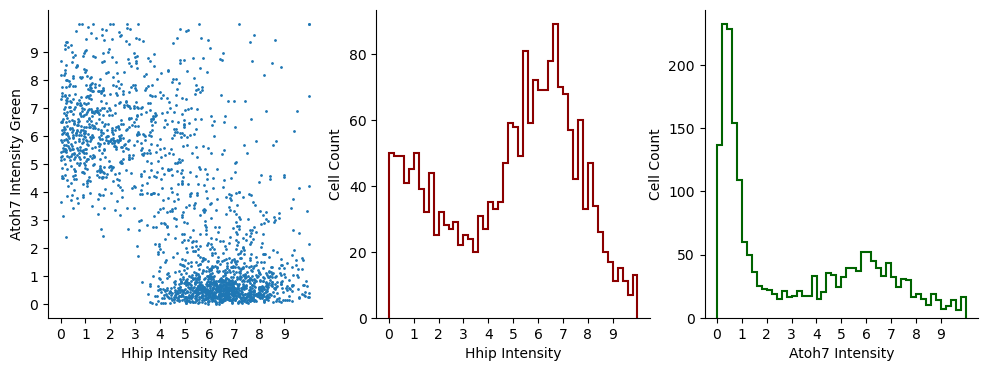

In [2]:
import matplotlib.pyplot as plt
DIR = '../../../../../../../'
files_joined = os.path.join(DIR, '*_*.csv')
list_files = glob.glob(files_joined)
li = []
for filename in list_files:
    df = pd.read_csv(filename, delim_whitespace=True)
    li.append(df)
data  = pd.concat(li, ignore_index=True)
del li

data.AnteriortoPostX = data.AnteriortoPostX*2.0756640 # um per pixel
data.VentraltoDorsalY = data.VentraltoDorsalY*2.0756640 # um per pixel
data = data[(data['Area'] >= 10)]
data.Area = data.Area*2.0756640*2.0756640
data.VentraltoDorsalY = data.VentraltoDorsalY -min(data.VentraltoDorsalY)
#data = data[(data['VentraltoDorsalY'] < 1000)]

data = data[(data['Scaled_Red'] >= 0)  & (data['Scaled_Green'] >= 0)]
data = data[(data['Scaled_Red'] <= 10)  & (data['Scaled_Green'] <= 10)]
genes = DIR.split("/")
#genes = genes[2]
genes = genes[5]
genes = genes.split(" ")
Rgene = genes[0]
Ggene = genes[1]

fig = plt.figure(figsize = (12, 4))
plt1 = plt.subplot2grid((1, 3), (0, 0))
plt1 = plt.scatter(data.Scaled_Red,data.Scaled_Green, s = 1)
plt.ylabel(Ggene+ " Intensity Green")
plt.xlabel(Rgene+ " Intensity Red")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
sns.despine()  

plt2 = plt.subplot2grid((1, 3), (0, 1))
plt2 = plt.hist(data.Scaled_Red, bins = 50, color='darkred',histtype=u'step', linewidth=1.5)
plt.ylabel("Cell Count")
plt.xlabel(Rgene+ " Intensity")
plt.xticks(np.arange(0, 10, 1))
sns.despine()

plt2 = plt.subplot2grid((1, 3), (0, 2))
plt3 = plt.hist(data.Scaled_Green, bins = 50, color='darkgreen',histtype=u'step', linewidth=1.5)
plt.ylabel("Cell Count")
plt.xlabel(Ggene+ " Intensity")
plt.xticks(np.arange(0, 10, 1))
sns.despine()
plt.savefig(DIR + 'preprocess.pdf' ,dpi = 300)

## Set cutoff value for each channel

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:1378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


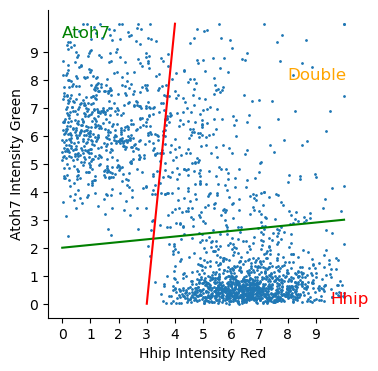

In [3]:
red_cutoff =   [3.0, 4.0]
green_cutoff = [2.0, 3.0]

fig = plt.figure(figsize = (4, 4))
plt1 = plt.scatter(data.Scaled_Red,data.Scaled_Green, s = 1)
plt.ylabel(Ggene+ " Intensity Green")
plt.xlabel(Rgene+ " Intensity Red")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
plt.plot([0,10], [green_cutoff[0],green_cutoff[1]],color ='Green')
plt.plot([red_cutoff[0],red_cutoff[1]],[0,10],color ='red')
plt.text(0, 9.5, Ggene, fontsize=12, color='Green')
plt.text(9.5, 0, Rgene, fontsize=12, color='Red')
plt.text(8, 8, 'Double', fontsize=12, color='Orange')
sns.despine()  
plt.savefig(DIR + 'cutoff.pdf' ,dpi = 300)

cutoff = ['redcutoff',red_cutoff,'greencutoff',green_cutoff]
txt= DIR + 'Cutoff.txt'
np.savetxt(txt, cutoff,fmt='%s')

In [4]:
green_flag = data['Scaled_Green'] >= (data['Scaled_Red']*0.1*(green_cutoff[1]-green_cutoff[0])+green_cutoff[0])
red_flag = data['Scaled_Red'] >= (data['Scaled_Green']*0.1*(red_cutoff[1]-red_cutoff[0])+red_cutoff[0])
data.loc[(green_flag  & red_flag),'Cell_Color'] = 'Double'
data.loc[(green_flag  & ~red_flag),'Cell_Color'] = 'Green'
data.loc[(~green_flag  & red_flag),'Cell_Color'] = 'Red'
data.loc[(~green_flag  & ~red_flag),'Cell_Color'] = 'Negative'
color_discrete_map={'Double': 'orange', 
                    'Green': 'green', 
                    'Red': 'red',
                    'Negative':'black'}

fig = px.scatter(x = data.Scaled_Red, y = data.Scaled_Green, color = data.Cell_Color,
                 color_discrete_map= color_discrete_map, 
                 width=450, height=400)
fig.update_traces(marker=dict(size=4.0))
fig.show()

fig = px.scatter(data,x = "AnteriortoPostX", y = "VentraltoDorsalY", 
                 hover_data=['Scaled_Red','Scaled_Green','Red','Green','Area'],
                 color = data.Cell_Color, 
                 color_discrete_map= color_discrete_map, 
                 width=450, height=400)
fig.update_traces(marker=dict(size=4.0))
fig.show()

## save result

In [5]:
data.loc[(data['VentraltoDorsalY'] <= 1100),'Location'] = 'VCN'
data.loc[(data['VentraltoDorsalY'] > 1100),'Location'] = 'DCN'
data.to_csv(DIR+'results.tsv')

## export 2-D histogram 

In [6]:
data1 = data[data['Cell_Color'].isin(["Green","Double","Red"])]
fig = px.density_heatmap(data1, 
                         x=data1.AnteriortoPostX, 
                         y=data1.VentraltoDorsalY,
                         facet_col=data1.Cell_Color,
                         nbinsx=20, nbinsy=25,
                         width=540, height=304,
                         range_color = [0,30],
                         marginal_x="histogram",
                         marginal_y="histogram",
                        #range_y = [0,1700],
                        #color_continuous_scale=px.colors.sequential.OrRd
                        )
fig.show()
fig.write_image(DIR + "heatmap_AnteriortoPost.pdf")


data1 = data[data['Cell_Color'].isin(["Green","Double","Red"])]
fig = px.density_heatmap(data1, 
                         x=data1.AnteriortoPostX, 
                         y=data1.VentraltoDorsalY, 
                         facet_row=data1.Cell_Color,
                         nbinsx=20, nbinsy=25,
                         width=328, height=525,
                        range_color = [0,10],
                        # range_y = [0,1700],
                         marginal_x="histogram",
                         marginal_y="histogram")

fig.show()
fig.write_image(DIR + "heatmap_VentraltoDorsal.pdf")

## export processing Figure

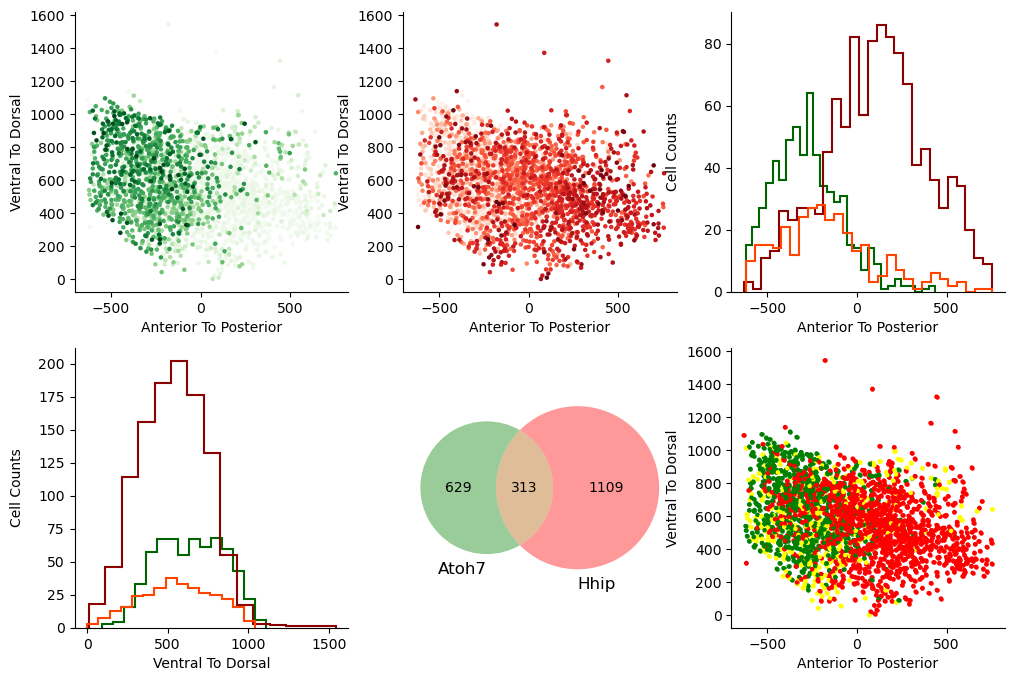

In [7]:
double_label = data[data['Cell_Color'].isin(['Double'])]
green_label = data[data['Cell_Color'].isin(['Green'])]
red_label = data[data['Cell_Color'].isin(['Red'])]

fig = plt.figure(figsize = (12, 8))
# Plot Green Channel intensity
ax1 = plt.subplot2grid((2, 3), (0, 0))
sortg = data.sort_values(by=['Scaled_Green'], ascending=True)
x = sortg.AnteriortoPostX
y = sortg.VentraltoDorsalY
y = y-min(y)
green  = sortg.Scaled_Green
ax1 = plt.scatter(x,y,c = green,cmap = 'Greens', s = 5)
ax1 = plt.ylabel("Ventral To Dorsal")
ax1 = plt.xlabel("Anterior To Posterior")
sns.despine() 

# Plot Red Channel intensity
ax2 = plt.subplot2grid((2, 3), (0, 1))
sortg = data.sort_values(by=['Scaled_Red'], ascending=True)
x = sortg.AnteriortoPostX
y = sortg.VentraltoDorsalY
y = y-min(y)
red  = sortg.Scaled_Red
ax2 = plt.scatter(x,y,c = red,cmap = 'Reds', s = 5)
ax2 = plt.ylabel("Ventral To Dorsal")
ax2 = plt.xlabel("Anterior To Posterior")
sns.despine() 

Dbc = double_label#data[data['Color'].isin(["Double_Positive"])]
Rc = red_label#data[data['Color'].isin(["Red"])]
Gc = green_label#data[data['Color'].isin(["Green"])]

ax3 = plt.subplot2grid((2, 3), (0, 2))
bin_n = round((max(data.AnteriortoPostX)-min(data.AnteriortoPostX))/50.0)
ax3 = plt.hist(Gc.AnteriortoPostX, bins = bin_n, color='darkgreen',histtype=u'step', linewidth=1.5)
ax3 = plt.hist(Rc.AnteriortoPostX, bins = bin_n, color='darkred',histtype=u'step', linewidth=1.5)
ax3 = plt.hist(Dbc.AnteriortoPostX,bins = bin_n, color='orangered',histtype=u'step', linewidth=1.5)
ax3 = plt.ylabel("Cell Counts")
ax3 = plt.xlabel("Anterior To Posterior")
sns.despine() 

ax4 = plt.subplot2grid((2, 3), (1, 0))
bin_n = round((max(data.VentraltoDorsalY)-min(data.VentraltoDorsalY))/100.0)
ax4 = plt.hist(Gc.VentraltoDorsalY, bins = bin_n, color='darkgreen',histtype=u'step', linewidth=1.5)
ax4 = plt.hist(Rc.VentraltoDorsalY, bins = bin_n, color='darkred',histtype=u'step', linewidth=1.5)
ax4 = plt.hist(Dbc.VentraltoDorsalY,bins = bin_n, color='orangered',histtype=u'step', linewidth=1.5)
ax4 = plt.ylabel("Cell Counts")
ax4 = plt.xlabel("Ventral To Dorsal")
sns.despine() 

ax5 = plt.subplot2grid((2, 3), (1, 1))
ax5 = venn2(subsets = (len(Gc),len(Rc),len(Dbc)), set_colors=('green','red'),set_labels = (Ggene, Rgene))

ax6 = plt.subplot2grid((2, 3), (1, 2))
ax6 = plt.scatter(Gc.AnteriortoPostX,Gc.VentraltoDorsalY,s = 5,color = 'green')
ax6 = plt.scatter(Rc.AnteriortoPostX,Rc.VentraltoDorsalY,s = 5,color = 'red')
ax6 = plt.scatter(Dbc.AnteriortoPostX,Dbc.VentraltoDorsalY,s = 5,color = 'yellow')
sns.despine() 
Color = data.Cell_Color
Color =Color.astype('string')
x = data.AnteriortoPostX
y = data.VentraltoDorsalY
palette1 =  ['green','red','yellow','white']
ax6 = plt.scatter(x,y,s = 5,
           c=[sns.color_palette(palette1)[x] for x in Color.map({"Green":0, "Red":1,"Double":2,"Negative":3})])
ax6 = plt.ylabel("Ventral To Dorsal")
ax6 = plt.xlabel("Anterior To Posterior")
fig.align_labels()
plt.savefig(DIR + 'Result.pdf' ,dpi = 300)

## processing Typical Image

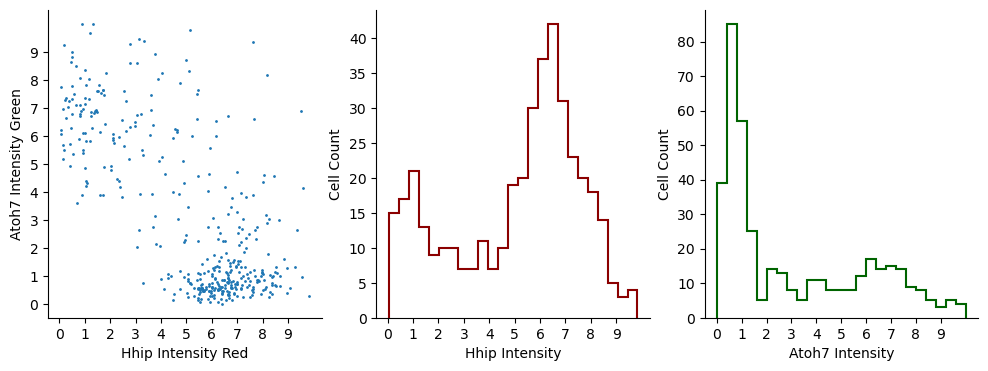

In [8]:
import matplotlib.pyplot as plt
filename = 'slide2_s1'
data = pd.read_csv(DIR+filename+'.csv', delim_whitespace=True)
data.AnteriortoPostX = data.AnteriortoPostX*2.0756640 # um per pixel
data.VentraltoDorsalY = data.VentraltoDorsalY*2.0756640 # um per pixel
data = data[(data['Area'] >= 10)]
data.Area = data.Area*2.0756640*2.0756640
data.VentraltoDorsalY = data.VentraltoDorsalY -min(data.VentraltoDorsalY)

data = data[(data['Scaled_Red'] >= 0)  & (data['Scaled_Green'] >= 0)]
data = data[(data['Scaled_Red'] <= 10)  & (data['Scaled_Green'] <= 10)]
genes = DIR.split("/")
#genes = genes[2]
genes = genes[5]
genes = genes.split(" ")
Rgene = genes[0]
Ggene = genes[1]

fig = plt.figure(figsize = (12, 4))
plt1 = plt.subplot2grid((1, 3), (0, 0))
plt1 = plt.scatter(data.Scaled_Red,data.Scaled_Green, s = 1)
plt.ylabel(Ggene+ " Intensity Green")
plt.xlabel(Rgene+ " Intensity Red")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 10, 1))
sns.despine()  

plt2 = plt.subplot2grid((1, 3), (0, 1))
plt2 = plt.hist(data.Scaled_Red, bins = 25, color='darkred',histtype=u'step', linewidth=1.5)
plt.ylabel("Cell Count")
plt.xlabel(Rgene+ " Intensity")
plt.xticks(np.arange(0, 10, 1))
sns.despine()

plt2 = plt.subplot2grid((1, 3), (0, 2))
plt3 = plt.hist(data.Scaled_Green, bins = 25, color='darkgreen',histtype=u'step', linewidth=1.5)
plt.ylabel("Cell Count")
plt.xlabel(Ggene+ " Intensity")
plt.xticks(np.arange(0, 10, 1))
sns.despine()
plt.savefig(DIR+ 'preporcessing_'+filename+'.pdf',dpi=300)

In [9]:
green_flag = data['Scaled_Green'] >= (data['Scaled_Red']*0.1*(green_cutoff[1]-green_cutoff[0])+green_cutoff[0])
red_flag = data['Scaled_Red'] >= (data['Scaled_Green']*0.1*(red_cutoff[1]-red_cutoff[0])+red_cutoff[0])
data.loc[(green_flag  & red_flag),'Cell_Color'] = 'Double'
data.loc[(green_flag  & ~red_flag),'Cell_Color'] = 'Green'
data.loc[(~green_flag  & red_flag),'Cell_Color'] = 'Red'
data.loc[(~green_flag  & ~red_flag),'Cell_Color'] = 'Negative'
data.to_csv(DIR+filename+'.tsv')

In [10]:
color_discrete_map={'Double': 'orange', 
                    'Green': 'green', 
                    'Red': 'red',
                    'Negative':'black'}

fig = px.scatter(x = data.Scaled_Red, y = data.Scaled_Green, color = data.Cell_Color,
                 color_discrete_map= color_discrete_map, 
                 width=450, height=400)
fig.update_traces(marker=dict(size=4.0))
fig.show()
fig.write_image(DIR + filename +"dot.pdf")

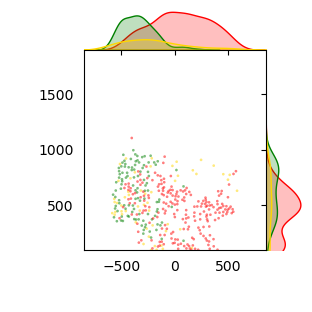

In [11]:
data1 = data[data['Cell_Color'].isin(["Green","Double","Red"])]
data1 = data1.sort_values(by=["Cell_Color"], ascending=True)
x=data1.AnteriortoPostX
y=data1.VentraltoDorsalY

palette = {'Green': 'green',
            'Red': 'red',
            'Double': 'gold'}
ax = sns.jointplot(data=data1, x=x, y=y, 
                  marginal_ticks= False,
              hue="Cell_Color",  #kind = 'kde',fill = False, #joint_kws ={'alpha':0.3},
              palette =palette, ec=data1["Cell_Color"].map(palette),#fc="none",
              xlim = (-850,850), ylim = (100,1900),
              s=3,alpha = 0.5,
              height=3.131,legend = False,space=0
             )
ax.ax_joint.set_xlabel(' ',  fontsize=16)
ax.ax_joint.set_ylabel(' ', fontsize=16)
ax.ax_joint.tick_params(width=0)

plt = ax.fig
#plt.show()
plt.savefig(DIR+ 'jointplot_'+filename+'.pdf',dpi=300)

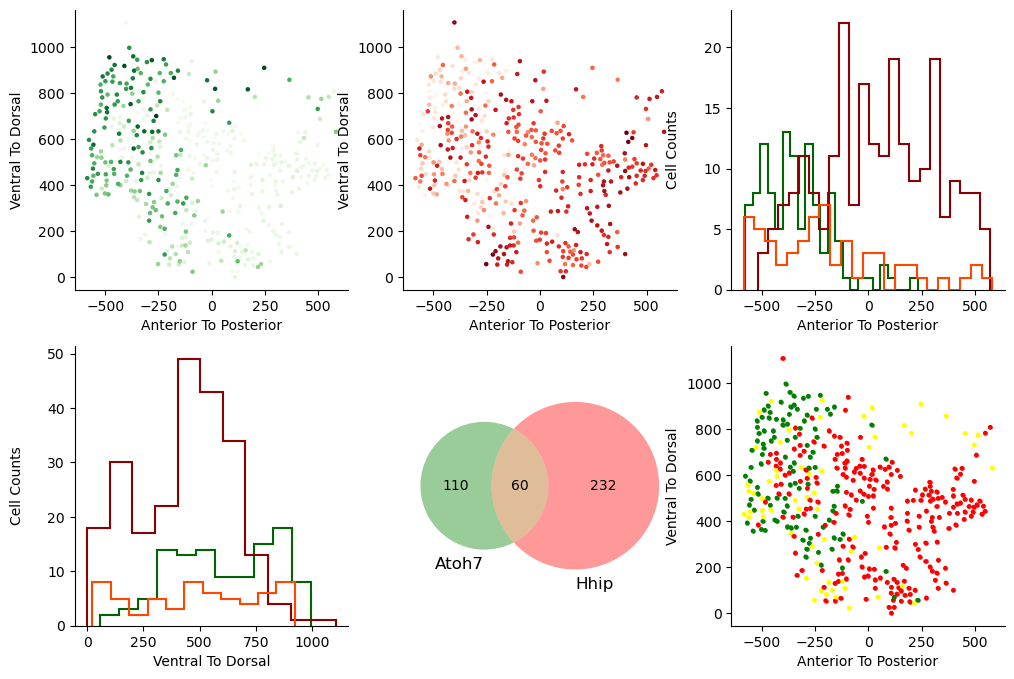

In [12]:
import matplotlib.pyplot as plt
double_label = data[data['Cell_Color'].isin(['Double'])]
green_label = data[data['Cell_Color'].isin(['Green'])]
red_label = data[data['Cell_Color'].isin(['Red'])]

fig = plt.figure(figsize = (12, 8))
# Plot Green Channel intensity
ax1 = plt.subplot2grid((2, 3), (0, 0))
sortg = data.sort_values(by=['Scaled_Green'], ascending=True)
x = sortg.AnteriortoPostX
y = sortg.VentraltoDorsalY
y = y-min(y)
green  = sortg.Scaled_Green
ax1 = plt.scatter(x,y,c = green,cmap = 'Greens', s = 5)
ax1 = plt.ylabel("Ventral To Dorsal")
ax1 = plt.xlabel("Anterior To Posterior")
sns.despine() 

# Plot Red Channel intensity
ax2 = plt.subplot2grid((2, 3), (0, 1))
sortg = data.sort_values(by=['Scaled_Red'], ascending=True)
x = sortg.AnteriortoPostX
y = sortg.VentraltoDorsalY
y = y-min(y)
red  = sortg.Scaled_Red
ax2 = plt.scatter(x,y,c = red,cmap = 'Reds', s = 5)
ax2 = plt.ylabel("Ventral To Dorsal")
ax2 = plt.xlabel("Anterior To Posterior")
sns.despine() 

Dbc = double_label#data[data['Color'].isin(["Double_Positive"])]
Rc = red_label#data[data['Color'].isin(["Red"])]
Gc = green_label#data[data['Color'].isin(["Green"])]

ax3 = plt.subplot2grid((2, 3), (0, 2))
bin_n = round((max(data.AnteriortoPostX)-min(data.AnteriortoPostX))/50.0)
ax3 = plt.hist(Gc.AnteriortoPostX, bins = bin_n, color='darkgreen',histtype=u'step', linewidth=1.5)
ax3 = plt.hist(Rc.AnteriortoPostX, bins = bin_n, color='darkred',histtype=u'step', linewidth=1.5)
ax3 = plt.hist(Dbc.AnteriortoPostX,bins = bin_n, color='orangered',histtype=u'step', linewidth=1.5)
ax3 = plt.ylabel("Cell Counts")
ax3 = plt.xlabel("Anterior To Posterior")
sns.despine() 

ax4 = plt.subplot2grid((2, 3), (1, 0))
bin_n = round((max(data.VentraltoDorsalY)-min(data.VentraltoDorsalY))/100.0)
ax4 = plt.hist(Gc.VentraltoDorsalY, bins = bin_n, color='darkgreen',histtype=u'step', linewidth=1.5)
ax4 = plt.hist(Rc.VentraltoDorsalY, bins = bin_n, color='darkred',histtype=u'step', linewidth=1.5)
ax4 = plt.hist(Dbc.VentraltoDorsalY,bins = bin_n, color='orangered',histtype=u'step', linewidth=1.5)
ax4 = plt.ylabel("Cell Counts")
ax4 = plt.xlabel("Ventral To Dorsal")
sns.despine() 

ax5 = plt.subplot2grid((2, 3), (1, 1))
ax5 = venn2(subsets = (len(Gc),len(Rc),len(Dbc)), set_colors=('green','red'),set_labels = (Ggene, Rgene))

ax6 = plt.subplot2grid((2, 3), (1, 2))
ax6 = plt.scatter(Gc.AnteriortoPostX,Gc.VentraltoDorsalY,s = 5,color = 'green')
ax6 = plt.scatter(Rc.AnteriortoPostX,Rc.VentraltoDorsalY,s = 5,color = 'red')
ax6 = plt.scatter(Dbc.AnteriortoPostX,Dbc.VentraltoDorsalY,s = 5,color = 'yellow')
sns.despine() 
Color = data.Cell_Color
Color =Color.astype('string')
x = data.AnteriortoPostX
y = data.VentraltoDorsalY
palette1 =  ['green','red','yellow','white']
ax6 = plt.scatter(x,y,s = 5,
           c=[sns.color_palette(palette1)[x] for x in Color.map({"Green":0, "Red":1,"Double":2,"Negative":3})])
ax6 = plt.ylabel("Ventral To Dorsal")
ax6 = plt.xlabel("Anterior To Posterior")
fig.align_labels()
plt.savefig(DIR + filename +'Result.pdf' ,dpi = 300)